In [1]:
from IPython.display import display
from IPython.display import HTML
#HTML Code to center all output in the jupyter notebook
display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))

In [2]:
# create toggle to show/hide code
display(HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" 
    value="Click here to toggle on/off the raw code."></form>'''))

In [3]:
# Script Content:
# Second Data Analytics Project
# Descriptive Analysis of OKCupid Profiles Data
# 1. Meta Analysis: Missing Values etc.
# 2. Basic Descriptive Stats
# 3. Essay Length/Ridgeline plots
# 4. Regional Analysis

# Authors: Andrew Boomer, Jacob Pichelmann

#### 0. Setup ####

## import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joypy
import os
import re
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from pandas.api.types import CategoricalDtype
import warnings
from tabulate import tabulate
import matplotlib.ticker as mtick
warnings.filterwarnings('ignore')

## set up paths

# Force the correct directory
if os.getcwd().split("/")[-1] == "CODE":
    os.chdir("..")
curr_dir = os.getcwd()

# If an output directory does not already exist, create one
if not os.path.isdir("OUTPUT"):
    os.mkdir("OUTPUT")
out_dir = curr_dir + "/OUTPUT/"
inp_dir = curr_dir + "/DATA/"

## import data
missing_values = ["nan", "-1"]  # account for income missing values = -1
df = pd.read_csv(inp_dir + '3-profiles.csv', na_values=missing_values)

# Introduction

This report provides a descriptive analysis of the OKCupid data collected by Kim and Escobedo-Land (2015). The report is structured as follows:
1. We start by discussing the data preparation steps we conduct in order to have the data ready for analysis.
2. We then show descriptive statistics of all variables of interest. To provide a concise overview we distinguish between numerical and categorical variables. We provide interactive plots to allow the reader to familiarize him/herself with the data and highlight noteworthy features of the data.
3. Moving to the main findings of this report, we provide an in-depth analysis of the amount of text that individuals share on OKCupid. We do so by comparing the length of all user essays across several dimensions of characteristics. We see this as (1) a proxy of communicativeness and (2) as an indication of willigness to share personal data online. Analyzing this dimension of the data hence delivers interesting insights into both the personality types of different sets of users and their handling of personal data online. 
4. Lastly, we discuss alternative options to visualize the main findings and conclude. 

Given that the main purpose of a dating site is to connect people that are interested in a romantic relationship, we distinguish between male and female users whenever possible. We see this as a sensible approach, as the descriptive analysis also indicates that the share of bisexual or gay users is relatively low (see the appendix for details).

# Data Preparation

We conduct a series of data preparation steps to get the data ready for analysis. One the one hand we transform values into more concise aggregates. This is necessary for variables where users are given the option to enter multiple values or different levels of seriousness. On the other hand we also construct new variables to record implicit information, i.e. the number of languages a user speaks. To this end we make the following transformations:

* *Ethnicity*: For ethnicity users list all ethnicities they belong to, hence we obtain a large number of distinct combinations of ethnic mixes. Still, this variable is very interesting so we transform it by (1) recording only the first entry and (2) creating a new variable that counts the number of ethnicities a user associates with, hence serving as a proxy for diversity. 
* *Languages*: We count the number of languages a user speaks, instead of analyzing the combinations of languages. 
* *Religion/Sign*: For both religion and astrological sign we collect (1) the religion/sign a user associates with and (2) the level of seriousness indicated which we transform into a numerical ranking. Moreover, we group religion into major types to aggregate the values further. Details are given in the code snippet below.
* *Pets*: We classify users into 'dog persons', 'cat persons', 'both' or 'neither' based on their pet preferences.
* *Offspring*: Similarly, we create variables indicating whether or not a user is a parent and/or if he/she wants to be a future parent, based on their stated preferences regarding offspring. 
* *Age*: We collect age groups in bins of 5-10 years starting from the age of 18, with smaller bins at younger ages, as we have more observations for these age groups (see section descriptive statistics for details).
* *Essays*: Lastly, and most importantly, we record the number of words written across all essays, after removing all html elements. 

To account for outliers we remove observations where the number of words written is 4 standard deviations larger then the mean. This is necessary, as we are ultimately interested in analyzing the distribution of the mean. Moreover, we exclude observations with clear data quality issues, such as users above the age of 100 and users with a height of smaller or equal to 26 inches. Removing those observations reduces our sample only slightly, as we still left with more than 57000 observations (compared to roughly 59000 observations in the raw data).

In [4]:
# 0. Data preparation

# record only first ethnicity
df['ethnicity_substr'] = df['ethnicity'].str.split().str[0].str.strip(',')

# count the number of ethnicities a user belongs to
df['num_ethnic'] = df['ethnicity'].apply(lambda x: len(str(x).replace(" ", "").
                replace("/", "").split(","))).astype(int)

# construct new variable that captures seriousness of religion (ranking)
df['religion_level'] = df['religion'].apply(lambda x: " ".join(str(x).split(" ")[1:]).
            replace("about it", "").replace("and", "").replace("but", "").strip())
df['religion_level'] = np.where(df['religion_level'] == '', 1,
                    np.where(df['religion_level'] == 'laughing', 2,
                    np.where(df['religion_level'] == 'not too serious', 3,
                    np.where(df['religion_level'] == 'somewhat serious', 4, 5))))
df['religion_level'] = df['religion_level'].astype(str)

# collect only religion
df['religion'] = df['religion'].apply(lambda x: str(x).split(" ")[0])

# construct new variable that captures seriousness of sign (ranking)
df['sign_level'] = df['sign'].str.replace("&rsquo;", "'").apply(lambda x: " ".join(str(x).split(" ")[1:]).
                     replace("and", "").replace("but", "").strip())
df['sign_level'] = np.where(df['sign_level'] == '', 1,
                np.where(df['sign_level'] == "it doesn't matter", 2,
                np.where(df['sign_level'] == "it's fun to think about", 3, 4)))
df['sign_level'] = df['sign_level'].astype(str)
# collect only sign
df['sign'] = df['sign'].str.replace("&rsquo;", "'").apply(lambda x: str(x).split(" ")[0])

# strip html elements of essay texts
essay_cols = df[[c for c in df if c.startswith('essay')]].columns
for col in essay_cols:
    df[col] =  [re.sub('<[^<]+?>','', str(x)) for x in df[col]]
    
# merge essays together
df['full_txt'] = df[essay_cols].apply(lambda row: ' '.join(set(row.values.astype(str))), axis=1)
df = df[df['full_txt'] != 'nan']

# count total number of words written
df['count_txt'] = df.apply(lambda row : len(row['full_txt'].split()), axis = 1)

# define educ groups
df.loc[:, 'education_grp'] = ""
df.loc[:, 'education_grp'] = np.where(df['education'].str.contains("|".join(['masters', 'ph.d', 'med', 'law'])), 
    'Advanced Degree', np.where(df['education'].str.contains('university'), 'University Degree', 
    np.where(df['education'].str.contains('high schoool'), 'High School', 'Other')))

# define age groups
df.loc[:, 'age_grp'] = ""
df.loc[:, 'age_grp'] = np.where(df['age'] < 25, "Early 20's",
                            np.where(df['age'] < 30, "Late 20's",
                            np.where(df['age'] < 35, "Early 30's",
                            np.where(df['age'] < 40, "Late 30's",
                            np.where(df['age'] < 50, "40's",
                            np.where(df['age'] < 60, "50's", 'Over 60'))))))

# use offspring variable to create parent variables
df['offspring'] = df['offspring'].str.replace("&rsquo;", "'")
df['IsParent'] = np.where(df['offspring'].str.contains("has&kid"), "Has Children", "No Children")
df['FutureParent'] = np.where(df['offspring'].str.contains("doesn't want"), "No More Kids", "More Kids")

# construct dog persons and cat persons
df['pet_grp'] = df['pets'].map({'likes dogs and likes cats' : 'Both', 'has cats' : 'Cat Person', 'likes cats' : 'Cat Person',
       'has dogs and likes cats' : 'Both', 'likes dogs and has cats' : 'Both',
       'likes dogs and dislikes cats' : 'Dog Person', 'has dogs' : 'Dog Person',
       'has dogs and dislikes cats' : 'Dog Person', 'likes dogs' : 'Dog Person',
       'has dogs and has cats' : 'Both', 'dislikes dogs and has cats' : 'Cat Person',
       'dislikes dogs and dislikes cats' : 'Neither', 'dislikes cats' : 'Dog Person',
        'dislikes dogs and likes cats' : 'Cat Person', 'dislikes dogs' : 'Cat Person'})

#Group religion based on coarser set of characteristics
df['religion_grp'] = np.where(df['religion'].isin(['agnosticism','atheism']), 'Non-Believer',
                np.where(df['religion'].isin(['christianity', 'catholicism', 'judaism', 'islam']), 'Major',
                np.where(df['religion'].isin(['buddhism', 'hinduism']), 'Eastern', 'Other')))

# count the number of languages a user speaks
df['num_langs'] = df['speaks'].apply(lambda x: len(str(x).replace(" ", "").replace("(fluently)", "").
                   replace("(poorly)", "").replace("(okay)", "").split(","))).astype(int)


# remove outliers for word count
df = df[df['count_txt'] <= df['count_txt'].mean() + (4 * np.sqrt(df['count_txt'].var()))]
df = df[df['age'] < 100]
df = df[~df['height'].isin([1, 4, 6, 8, 9, 26])]

### Intermezzo: Checking missing values
Before starting the actual analysis we need to check if there are caveats to the data which have to be accounted for. A heatmap of missing values delivers insights about data availability at a glance. Here every bright spot corresponds to a missing value in the respective column. We can see that the majority of users do not disclose their income. This otherwise highly interesting variable can hence not be seen as representative of the observed population. Similarly, we observe many missing values for the variable offspring, so any findings in this regard and also the derived variables _IsParent_ and _FutureParent_ have to be used with caution.

<AxesSubplot:>

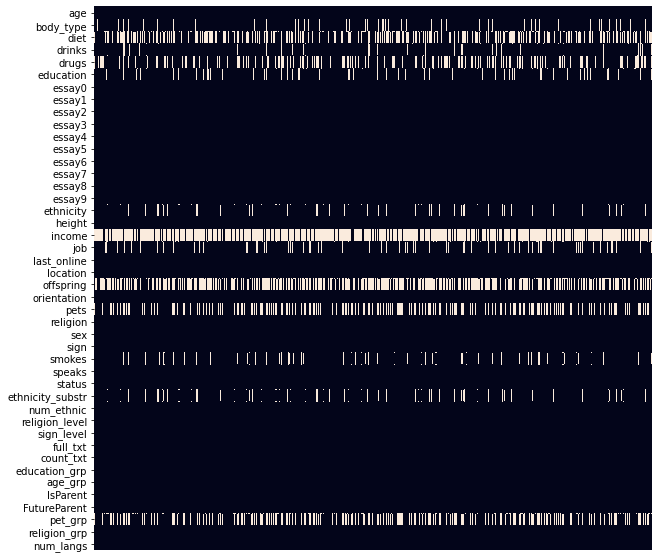

In [5]:
#### 1. Meta Analysis ####

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df.isnull().T, cbar=False, xticklabels=False) #Generate missing value heatmap

# Descriptive Statistics

As outlined in the introduction we provide descriptive statistics of all variables of interest across males and females. Given the nature of the data at hand we start with a slightly unusal exercise. For a set of characteristics we record the most frequent value for male and female users separately. This gives an indication about how a typical 'hybrid' user looks like according to our data set. We then continue by analyzing the numerical variables in the data set. Here we provide both summary statistics and line plots to give insights about their distributions. Finally, we move to the remaining categorical variables. Here we provide bar plots of frequency counts of the variables which are used in the main analysis. The interested reader can find similar visualizations for all categorical variables in the appendix. 

### Hybrid User
The table below shows the typical male and female users, i.e. having the most common characteristics by group.

In [6]:
# 2.2.1
# what does most common man/women in data set look like?
# create helper function that returns most frequent characteristic
def max_freq(col, data = df):
    freq = data[col].value_counts().reset_index()
    freq_max = freq[freq[col] == max(freq[col])]['index'][0]
    return freq_max

#Separate data on gender to look at most frequent value by group
males = df[df['sex'] == 'm']
females = df[df['sex'] == 'f']

#List of columns to analyze most frequent characteristics by group on
cols = ['age', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'ethnicity',
        'height', 'income', 'job']

res_male = [] #Initialize list ot store male values
for col in cols:
    res_male.append(max_freq(col, males)) #Append most frequent value to male list

res_female = [] #Initialize list ot store female values
for col in cols:
    res_female.append(max_freq(col, females)) #Append most frequent value to female list

# put results in a table
hybrid = pd.DataFrame({'F': res_female, 'M': res_male}) #Collect values into dataframe
hybrid.index = cols #Rename index to initial column names

# display(hybrid) # we can print this in a sentence?
print(tabulate(hybrid, headers=['Female', 'Male'],
               tablefmt='fancy_grid', stralign='center', floatfmt='g'))


## Add sentence that describes hybrid user. 
print('''We find that the typical female OKCupid user is {} years old,
has an {} body type, eats {} and earns {} USD.'''.format(hybrid['F'].loc['age'], hybrid['F'].loc['body_type'],
                                                    hybrid['F'].loc['diet'], hybrid['F'].loc['income']))
print('')
print('''On the other hand, the typical male OKCupid user is {} years old,
has an {} body type, eats {} and earns {} USD.'''.format(hybrid['M'].loc['age'], hybrid['M'].loc['body_type'],
                                                    hybrid['M'].loc['diet'], hybrid['M'].loc['income']))

╒═══════════╤═══════════════════════════════════╤═══════════════════════════════════╕
│           │              Female               │               Male                │
╞═══════════╪═══════════════════════════════════╪═══════════════════════════════════╡
│    age    │                25                 │                26                 │
├───────────┼───────────────────────────────────┼───────────────────────────────────┤
│ body_type │              average              │             athletic              │
├───────────┼───────────────────────────────────┼───────────────────────────────────┤
│   diet    │          mostly anything          │          mostly anything          │
├───────────┼───────────────────────────────────┼───────────────────────────────────┤
│  drinks   │             socially              │             socially              │
├───────────┼───────────────────────────────────┼───────────────────────────────────┤
│   drugs   │               never               │     

### Numerical variables

In the initial data set only 3 variables are numerical. We extend this set by 3 additional variables, as outlined in the section on data preparation:
1. Number of words written by user across all essays.
2. Number of words in ethnicity (i.e. a measure of diversity).
3. Number of languages spoken by a user.

We provide a table of summary statistics for each of those variables. We chose to present these values in a table as we found an additional set of plots to be overwhelming and to actually hinder the idea of providing a quick overview of the numerical data. Moreover, we pair this with line plots of all variables, where we distinguish between genders male and female. In these plots the y-axis counts the number of observations and the x-axis is the value of the variable. We chose a line plots, as the variables are continues, hence we observe relatively smooth curves. 

Our main takeaway from these plots is that the number of words is relatively equally distributed across males and females. Because of this finding we decided to not distinguish between male and female users in the main analysis. Moreover, we see that the income gap between men and women is especially pronounced for low and high incomes, but narrows for the mean income in our data. However, we have to keep in mind that most users do not disclose their income, hence we have to take this finding with a grain of salt. All these plots also show that we have more men than women in the data. These difference is the most pronounced for younger ages, between 20 and 40. Moreover, we see that men are taller than women. This is not surprising but a good sanity check for the data at hand. Lastly, we can see that the distribution for the number of languages spoken as well as the number of ethnicities are similar between men and women.

╒═══════╤═════════╤══════════╤══════════╤══════════════╤═════════════╤═════════════╕
│       │   age   │  height  │  income  │  num_ethnic  │  count_txt  │  num_langs  │
╞═══════╪═════════╪══════════╪══════════╪══════════════╪═════════════╪═════════════╡
│ count │  57435  │  57433   │  11020   │    57435     │    57435    │    57435    │
├───────┼─────────┼──────────┼──────────┼──────────────┼─────────────┼─────────────┤
│ mean  │ 32.2857 │ 68.2907  │  104902  │   1.15435    │   359.445   │   1.85827   │
├───────┼─────────┼──────────┼──────────┼──────────────┼─────────────┼─────────────┤
│ std   │ 9.41683 │ 3.94219  │  202883  │   0.530845   │   253.561   │   1.03713   │
├───────┼─────────┼──────────┼──────────┼──────────────┼─────────────┼─────────────┤
│ min   │   18    │    3     │  20000   │      1       │      1      │      1      │
├───────┼─────────┼──────────┼──────────┼──────────────┼─────────────┼─────────────┤
│ 25%   │   26    │    66    │  20000   │      1       │     174 

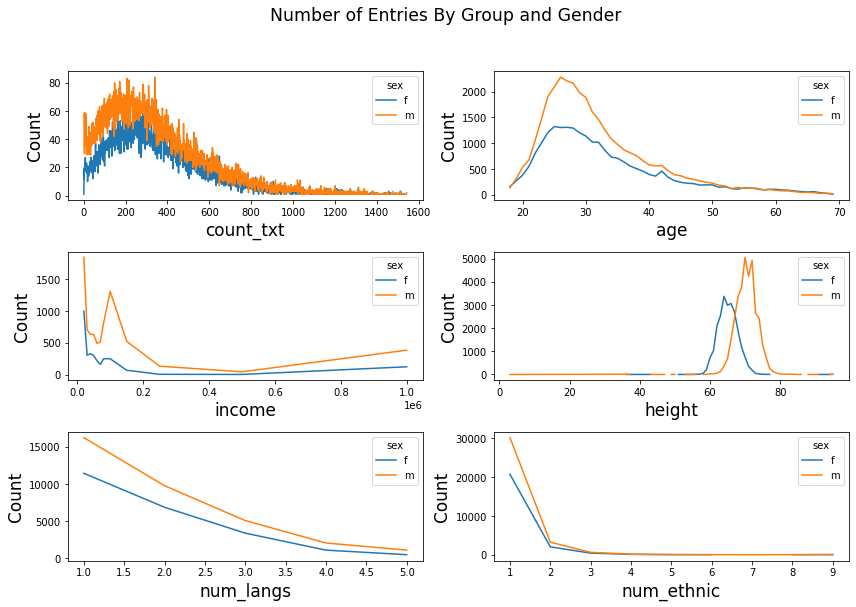

In [7]:
#### 2. Basic Descriptive Stats ####

# 2.1 Numerical variables
# 2.1.1 summary statistics
print(tabulate(df.describe(), headers='keys', tablefmt='fancy_grid', numalign='center', floatfmt='g'))

#Create list of numerical variables
num_cats = ['count_txt', 'age', 'income', 'height', 'num_langs', 'num_ethnic']

#Create a list of subplots in order to plot in grid
fig, axes = plt.subplots(ncols=2, nrows=(np.math.floor(len(num_cats)/2)), figsize=(14, 9))
fig.subplots_adjust(hspace=0.4, wspace=0.2) #Put some whitespace between graphs
fig.suptitle("Number of Entries By Group and Gender", fontsize='xx-large')
#Loop through the numerical columns
for i in range(len(num_cats)):
    cat = num_cats[i] #Get current column
    #Get the row and column of the current plot axis
    curr_row = np.math.floor(i / 2)
    curr_col = i % 2
    #plot the current column on axis
    plot_df = df.groupby([cat, 'sex']).size().unstack().plot(ax = axes[curr_row, curr_col])
    x = axes[curr_row, curr_col].get_xlabel()
    axes[curr_row, curr_col].set_xlabel(x, fontsize=17)
    #Get the label for the y-axis and make the font size bigger
    axes[curr_row, curr_col].set_ylabel('Count', fontsize=17)

### Categorical variables

For the remaining categorical variables our main interest lies in analyzing frequency counts to see if certain characteristics are more or less common. To get a concise understanding of the data at hand we provide a set of bar plots to visualize the frequency counts. Here we focus on the key variables which are used in the main analaysis, but the interested reader can find similar plots for all categorical variables in the appendix. The set of variables considered in the subsequent analyses consists of
* _sign_level_, which indicates how serious a user is about his/her astrological sign,
* _status_, which captures self-proclaimed dating status,
* _religion_grp_, which aggregates a users religious affiliation to 4 main groups,
* _pet_grp_, which denotes whether the user likes cats or dogs,
* _age_grp_, which bins age into groups and
* _num_languages_, which indicates the number of languages a user speaks.

As the latter is a numerical variable its descriptive statistics are shown in the preceding section.

Visualizing these frequency counts is an essential step in understanding the demographical characteristics of our data. We can see that most of our groups of interest are well represented. Solely for the self-proclaimed status of a user there is evidence for limited variation. This characteristic of the data has to be kept in mind when evaluating the findings of the main analysis.

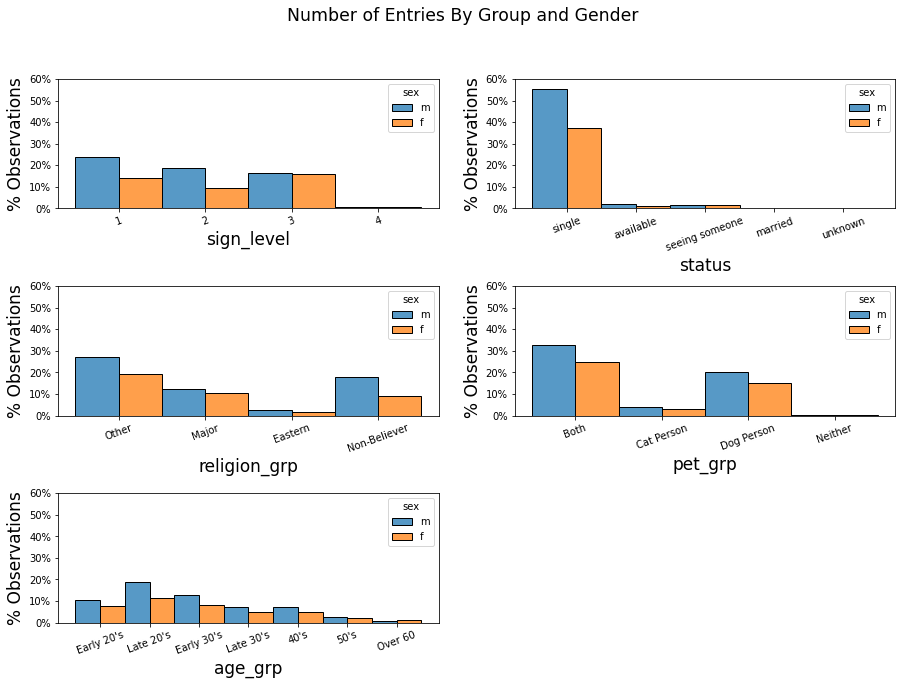

In [8]:
# 2.2.2 Categorical plots

#Get list of columns to group the data by to analyze differences in length of text written
categories = ['sign_level', 'status', 'religion_grp', 'pet_grp', 'age_grp']
#These categorical variables need to have a forced order
cat_order = {'age_grp' : ["Early 20's", "Late 20's", "Early 30's", "Late 30's", "40's", "50's", 'Over 60'],
             'religion_grp' : ['Other', 'Major', 'Eastern', 'Non-Believer'],
             'pet_grp' : ['Both', 'Cat Person', 'Dog Person', 'Neither'],
             'status' : ['single', 'available', 'seeing someone', 'married', 'unknown']}

#Define a function for plotting these bars
def plot_bar(data, category, ax, orient):
    data = data.copy(deep=True) #Copy the data
    #Force to categorical with predefined order
    try: 
        cat = CategoricalDtype(cat_order[category], ordered=True)
    except:
        cat = CategoricalDtype(data[category].dropna().unique().tolist(), ordered=True)
    data[category] = data[category].astype(cat) #Cast as categorical
    
    if orient == 'v': #If we want vertical bars
        curr = sns.histplot(data[data[category].notna()], x=category, hue="sex", multiple="dodge", ax=ax,
                           stat='probability')
        ax.xaxis.set_tick_params(rotation=20) #Rotate the text 20 degrees
        #Get the label for the x-axis and make the font size bigger
        x = ax.get_xlabel()
        ax.set_xlabel(x, fontsize=17)
        #Get the label for the y-axis and make the font size bigger
        ax.set_ylabel('% Observations', fontsize=17)
        ax.set(ylim=(0, 0.6))
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    else: #If horizontal bars
        curr = sns.histplot(data[data[category].notna()], y=category, hue="sex", multiple="dodge", ax=ax,
                           stat='probability')
        #Get the label for the y-axis and make the font size bigger
        y = ax.get_ylabel()
        ax.set_ylabel(y, fontsize=17)
        #Get the label for the x-axis and make the font size bigger
        ax.set_xlabel('% Observations', fontsize=17)
        ax.set(xlim=(0, 0.6))
        ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
#Initialize a grid of subplots
fig, axes = plt.subplots(ncols=2, nrows=(np.math.floor(len(categories)/2))+1, figsize=(15, 10))
fig.suptitle("Number of Entries By Group and Gender", fontsize='xx-large') #Set the figure title
fig.subplots_adjust(hspace=0.6, wspace=0.2) #Put some whitespace in between
for i in range(len(categories)):
    cat = categories[i] #Get the current column variable
    curr_row = np.math.floor(i / 2) #Get the current row and column of the subplot axis
    curr_col = i % 2
    plot_bar(df, cat, axes[curr_row, curr_col], 'v') #Call the plot bar function

fig.delaxes(axes[2][1])

# Main findings

We now shift our focus to analyzing the communicativeness of OKCupid users. Given that the variable of interest is numerical we are interested in its distribution across different types of users. The granularity of the data allows answering highly interesting question i.e. whether religious individuals are more talkative than non religious or if taking astrology seriously correlates with lengthier essays. We might even make an assessment whether or not pet persons are indeed prone to over-sharing. We decided against distinguishing between genders, as initial descriptive statistics did not strong differences between the groups. Initially we intended to use small multiples to visualize the distribution for every group of interest, yielding a so-called ridgeline plot. However, after considering our question and the nature of the data further, we realized that ridgeline plots are better suited to data with at least one clear ordinal component, such as time series data. With time series data for example, the progression of the distributions is readily interpreted. Understanding the progression of the distributions in a ridgeline plot grouped by categorical variables is not so clear.

To address the data and the shortcomings of the ridgeline plot, we decided that a more basic visualization is actually preferable in this case, a boxplot. With a box plot, we address the issue of the differences being obscured by the overlapping density functions, and the boxplots clearly mark the medians of each distribution (by a line), which aids in comprehension.

Below we show boxlots for our selected set of variables. We can derive the following insights about the communicativeness of OKCupid users.

* **People who take astrology seriously, write more.** However, this relationship is reversed at the limit, as users taking it very seriously (level 4), write less. An explanation with limited plausibility is that people fully believing that their fate is determined by their sign do not have to worry about writing an extensive text, as the stars have already decided on their ideal romantic partner. Further research might shed light on this interesting dynamic.
* **Polyglott users tend to write lengthier essays.** It is plausible that speaking many languages correlates with an expressive character, with the latter being captured to some extent by the word count.
* **Available users write more than single users.** As this variable is self proclaimed we suspect that this relationship is driven by the fact that 'available' users are more serious about their dating activities on OKCupid and hence provide more information. However, this finding could also stem from the differences in group sizes and should hence be taken with a grain of salt.
* **Non-believers are the most communicative.** We suspect that placing your fate in an omnipotent entity frees you from the pressure of writing lenghty essays, as other forces are determining your next relationship.
* **Cat persons need to make up for their uncommunicative pets.** Users identifying as cat persons or as both a cat and a dog person tend to write more. This could be driven by the fact that cats tend to ignore their owners, hence users feel the need to make up for this lack of communication. Further research could uncover interesting patterns.
* **Users around the age of 30 write the most.** We argue that this finding is driven by the fact that this age is the prime age for starting a serious relationship and settling down, hence these users take their online dating the most serious.

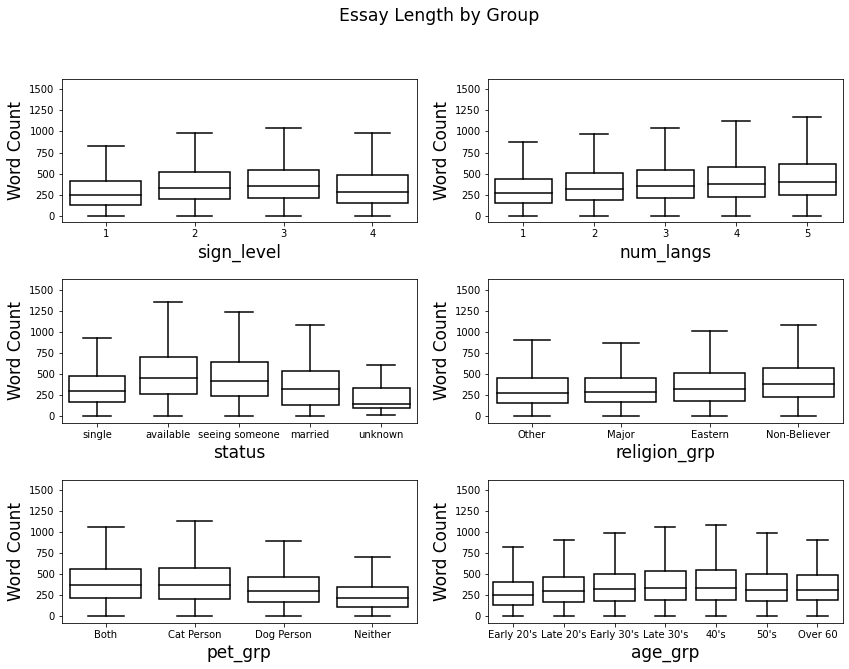

In [9]:
#Redefine list of categories
categories = ['sign_level', 'num_langs', 'status', 'religion_grp', 'pet_grp', 'age_grp']

#Initialize subplot figure
fig, axes = plt.subplots(ncols=2, nrows=(np.math.floor(len(categories)/2)), figsize=(14, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.2) #Add horizontal and vertical white space for clarity
fig.suptitle("Essay Length by Group", size='xx-large')

#Loop through the columns to group by and visualize
for i in range(len(categories)):
    cat = categories[i] #Get the current category
    #Get the current row and column of the subplot
    curr_row = np.math.floor(i / 2)
    curr_col = i % 2
    try: #Try to force the order of the column if necessary
        x_order = cat_order[cat]
        curr_box = sns.boxplot(data=df, orient='v', x=cat, y='count_txt', fliersize=0,
                               order = x_order, ax = axes[curr_row, curr_col], color='white')
    except:
        curr_box = sns.boxplot(data=df, orient='v', x=cat, y='count_txt', fliersize=0,
                               ax = axes[curr_row, curr_col], color='white')
    
    # Get the label for the x-axis and make the font size bigger
    x = axes[curr_row, curr_col].get_xlabel()
    axes[curr_row, curr_col].set_xlabel(x, fontsize=17)
    # Get the label for the y-axis and make the font size bigger
    axes[curr_row, curr_col].set_ylabel('Word Count', fontsize=17)
    
    # iterate over boxes
    for i, box in enumerate(curr_box.artists):
        box.set_edgecolor('black')
        box.set_facecolor('white')

        # iterate over whiskers and median lines
        for j in range(6*i,6*(i+1)):
             curr_box.lines[j].set_color('black')

# Alternative Visualization

### Ridgeline plots

Building on the previous discussion, we alternatively provide a set of ridgeplots below to illustrate their short comings in highlighting our findings. We can distinctly see that they are more useful when the y-axis is ordinally ranked, as it is the case with the number of languages. Still, while with a bit of imagnination we can see a slight trend towards lengthier essays for this variable, comparing distributions is difficult. It gets even more difficult, when the y-axis is categories without an ordinal ranking, as is illustrated here with the pet groups. The plot gives indication that users wo are neither a cat nor dog person write less, but it is hard to make any further comparisons across groups.

<Figure size 432x288 with 0 Axes>

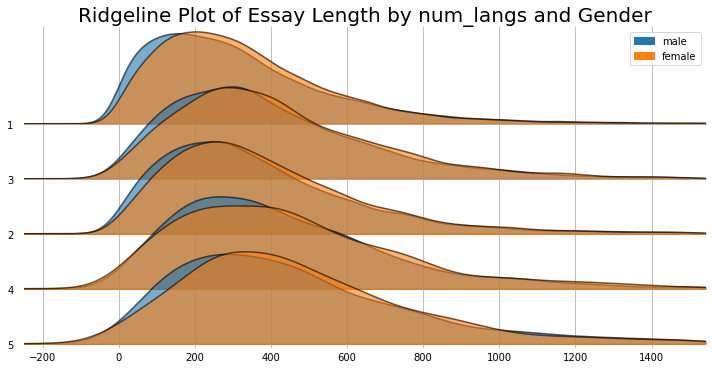

<Figure size 432x288 with 0 Axes>

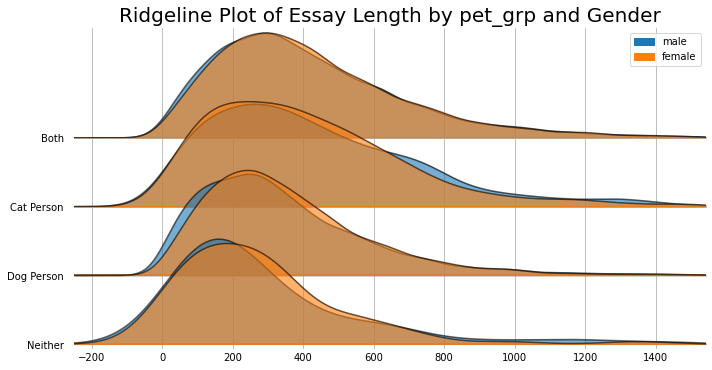

In [10]:
#### 3. Essay Length/Ridgeline plots ####

#To create ridgeline plots we need to duplicate the data for male and female genders
df['male'] = df['count_txt']
df['female'] = df['count_txt']
df.loc[df['sex']=='f', 'male'] = np.nan
df.loc[df['sex']=='m', 'female'] = np.nan

#Define ridgeline plotting function
def plot_ridgeline(data, category, size):
    # prep data
    data = data.copy(deep=True) #Copy data
    upper_x = data['count_txt'].max() #Get the maximum x_value to use for graph
    #Force the ordering of the variable if necessary
    try: 
        cat = CategoricalDtype(cat_order[category], ordered=True)
    except:
        cat = CategoricalDtype(data[category].dropna().unique().tolist(), ordered=True)
    data[category] = data[category].astype(cat) #Cast as categorical

    plt.figure() #Joy plots require a new figure for each plot
    joypy.joyplot(
    data=data[['male', 'female', category]],
    by=category,
    x_range=(-250, upper_x), #Define x_range
    column=['male', 'female'], #Two columns to plot
    ylim='own', #Each graph has its own y limit
    figsize=size,
    legend=True, #Give a legend
    alpha = 0.6,
    grid='both')
    plt.title('Ridgeline Plot of Essay Length by ' + category + ' and Gender', fontsize=20)

# interact(plot_ridgeline, data=fixed(df), category = categories)
categories = ['num_langs', 'pet_grp']
for cat in categories:
    plot_ridgeline(df, cat, (10, 5))

### Violin plots

Another alternative that immediately comes into mind when working with box plots are violin plots. Compared to box plots they have the advantage of additionally visualizing the distribution of each group, making comparison across groups of different sizes possible. However, in the case of our data and confirmed by our descriptive statistics we find that group sizes do not differ much for most variables, hence the violin plots just add a layer of complexity that makes intuitive visual comparison between groups more difficult. This is not the case, however, for the _status_ variable, where the violin plots give some indication of a clustering of values and hence provide more information than the boxplot. Generally, in our opinion showing the median as a point instead of a line makes comparison more difficult.

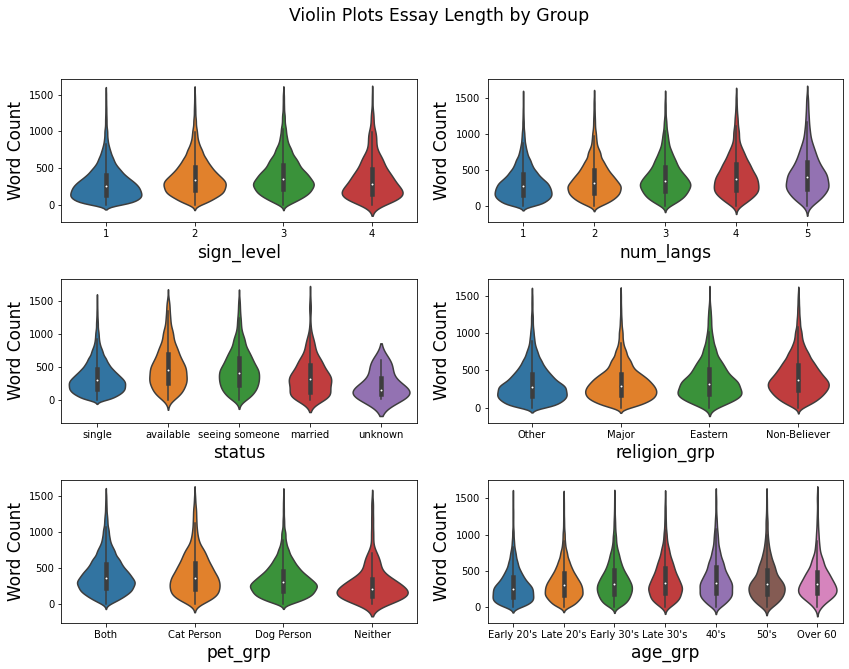

In [11]:
categories = ['sign_level', 'num_langs', 'status', 'religion_grp', 'pet_grp', 'age_grp']

#Generate the grid of subplots to put the violin plots on
fig, axes = plt.subplots(ncols=2, nrows=(np.math.floor(len(categories)/2)), figsize=(14, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle("Violin Plots Essay Length by Group", size='xx-large')

for i in range(len(categories)):
    cat = categories[i]
    curr_row = np.math.floor(i / 2)
    curr_col = i % 2
    try:
        x_order = cat_order[cat]
        sns.violinplot(data=df, orient='v', x=cat, y='count_txt', order = x_order, ax = axes[curr_row, curr_col])
    except:
        sns.violinplot(data=df, orient='v', x=cat, y='count_txt', ax = axes[curr_row, curr_col])
    
    #Get the label for the x-axis and make the font size bigger
    x = axes[curr_row, curr_col].get_xlabel()
    axes[curr_row, curr_col].set_xlabel(x, fontsize=17)
    #Get the label for the y-axis and make the font size bigger
    axes[curr_row, curr_col].set_ylabel('Word Count', fontsize=17)

# Appendix
## Data Dictionary

In [12]:
col_desc = {'age': "User Age in Years",
 'body_type': "User Reported Fitness Level",
 'diet': "User Reported Diet Preferences",
 'drinks':"User Reported Alcoholic Consumption",
 'drugs':"User Reported Drug Use Frequency",
 'education':"User Highest Level of Education Atttained",
 'essay0': "First Portion of User Essay",
 'essay1': "Second Portion of User Essay",
 'essay2': "Third Portion of User Essay",
 'essay3': "Fourth Portion of User Essay",
 'essay4': "Fifth Portion of User Essay",
 'essay5': "Sixth Portion of User Essay",
 'essay6': "Seventh Portion of User Essay",
 'essay7': "Eigth Portion of User Essay",
 'essay8': "Ninth Portion of User Essay",
 'essay9': "Tenth Portion of User Essay",
 'ethnicity': "User Reported Race/Ethnicity",
 'height': "User Reported Height in Inches",
 'income': "Annual Income in Dollars",
 'job': "Industry Sector of Employment",
 'last_online': "Last Login on Website in Minutes",
 'location': "City of User Residence",
 'offspring': "Whether User has Children and Wants Them",
 'orientation': "User Sexual Orientation",
 'pets': "User Preferences of Dogs and Cats",
 'religion': "General Religious Beliefs of User",
 'sex': "User Gender",
 'sign': "User Zodiac Sign",
 'smokes': "Frequency of Cigarette Smoking",
 'speaks': "Languages User Speaks",
 'status': "User Current Relationship Status"}

print(tabulate(col_desc.items(), headers=['Column', 'Column Description'],
               tablefmt='fancy_grid', stralign='center'))

╒═════════════╤═══════════════════════════════════════════╕
│   Column    │            Column Description             │
╞═════════════╪═══════════════════════════════════════════╡
│     age     │             User Age in Years             │
├─────────────┼───────────────────────────────────────────┤
│  body_type  │        User Reported Fitness Level        │
├─────────────┼───────────────────────────────────────────┤
│    diet     │      User Reported Diet Preferences       │
├─────────────┼───────────────────────────────────────────┤
│   drinks    │    User Reported Alcoholic Consumption    │
├─────────────┼───────────────────────────────────────────┤
│    drugs    │     User Reported Drug Use Frequency      │
├─────────────┼───────────────────────────────────────────┤
│  education  │ User Highest Level of Education Atttained │
├─────────────┼───────────────────────────────────────────┤
│   essay0    │        First Portion of User Essay        │
├─────────────┼─────────────────────────

## Additional Plots

These barplots show frequency counts for the remaining categorical variables that have not been used in the main analysis.

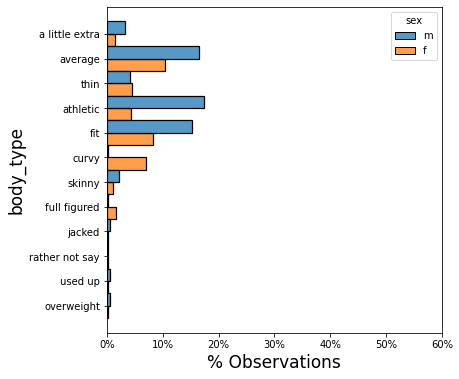

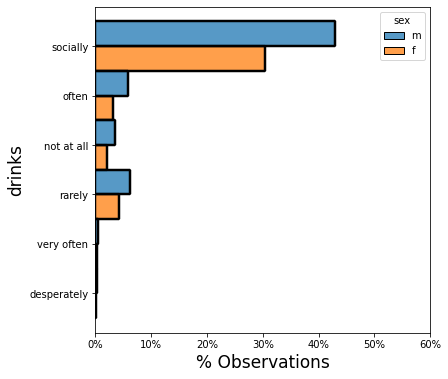

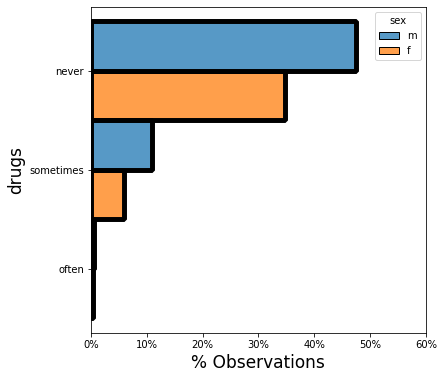

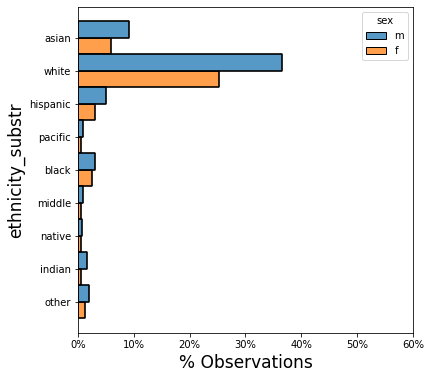

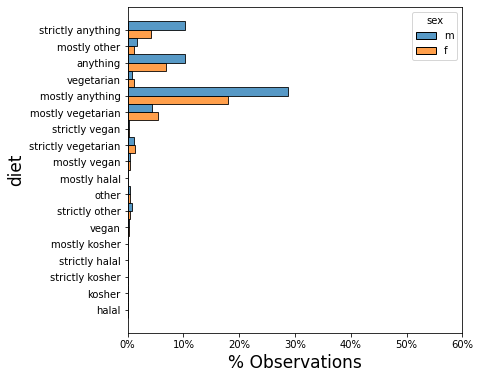

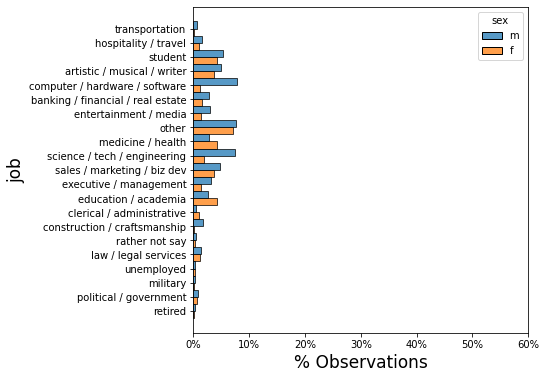

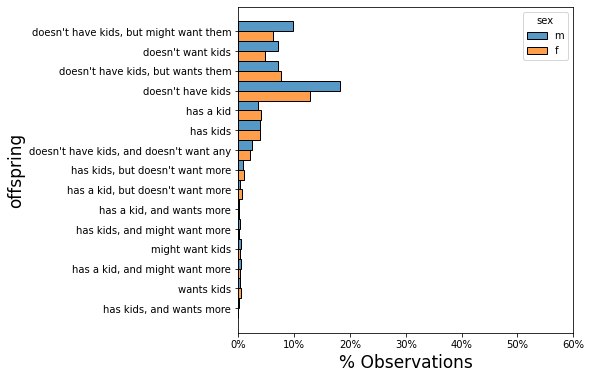

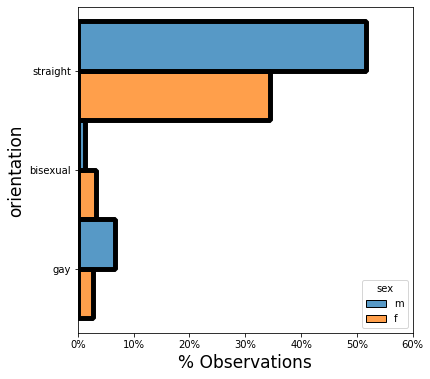

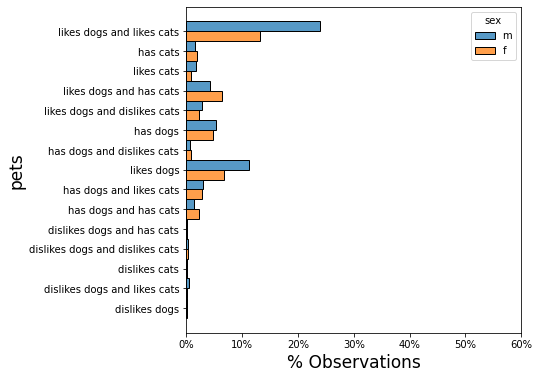

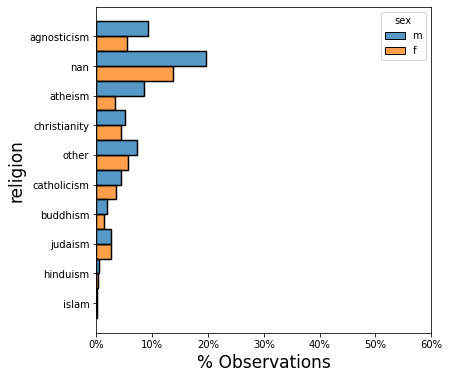

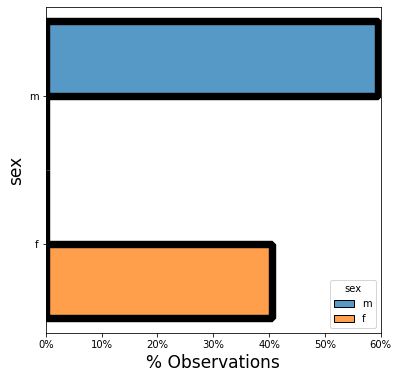

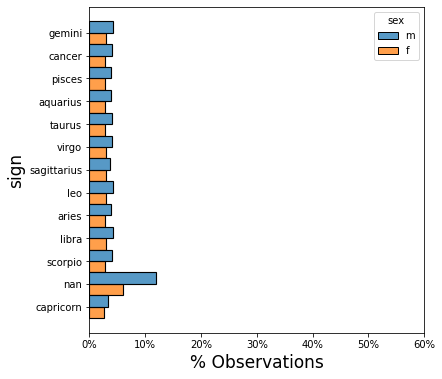

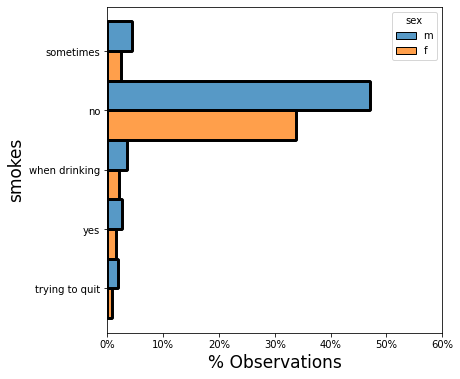

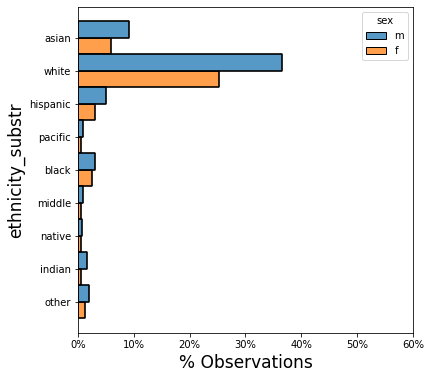

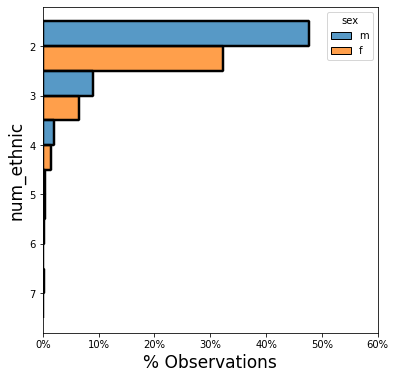

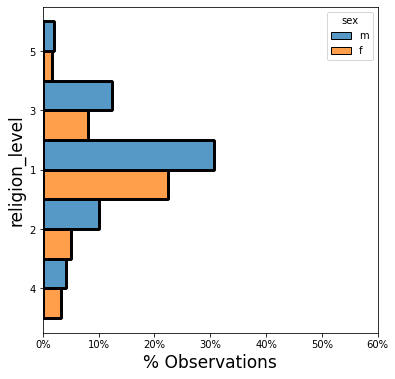

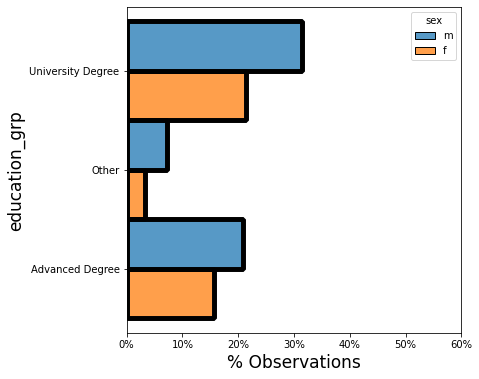

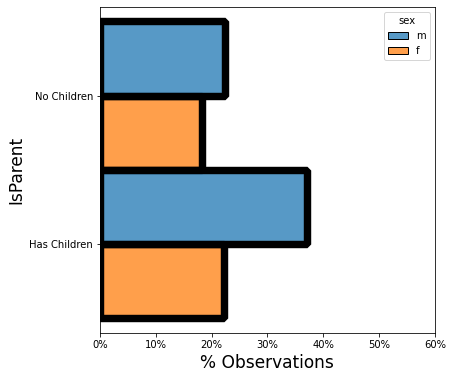

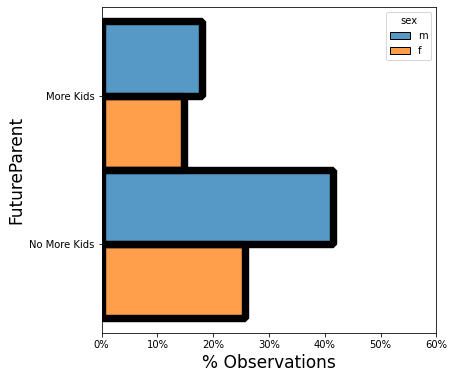

In [13]:
full_cats = ['body_type', 'drinks', 'drugs', 'ethnicity_substr', 'diet', 'job', 'offspring', 
              'orientation', 'pets', 'religion', 'sex', 'sign', 'smokes', 'ethnicity_substr', 'num_ethnic',
             'religion_level', 'education_grp', 'IsParent', 'FutureParent']

for i in range(len(full_cats)):
    cat = full_cats[i]
    fig, ax = plt.subplots(1, 1, figsize = (6, 6))
    plot_bar(df, cat, ax, 'h')